# HW 1

## Import libraries

In [ ]:
display_figures = True

def display_correlation_matrix(X,y):
    if not display_figures:
        return

    Xy = pd.concat([X, y], axis=1)
    corr = Xy.corr()
    f = plt.figure(figsize=(20, 20))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(Xy.shape[1]), Xy.columns, fontsize=14, rotation=90)
    plt.yticks(range(Xy.shape[1]), Xy.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

In [2]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import matplotlib.pyplot as plt # another visualization library
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from skrebate import ReliefF
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from mlxtend.feature_selection import SequentialFeatureSelector

warnings.filterwarnings('ignore')

## Part 1 - load the data


In [3]:
file = 'virus_hw2.csv'

In [4]:
df = pd.read_csv(file)

In [5]:
df.drop(labels=['Address', 'Job', 'PatientID'], axis=1, inplace=True)

## Part 2 - Split to train, validate and test sets

The ratio is 70% for training, 15% for validating and 15% for testing.

In [6]:
X = df.drop(labels=['TestResultsCode'], axis=1)
y = df[['TestResultsCode']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=1) # 0.176 x 0.85 = 0.15


## Part 3 - Fix the data types

Fixing CurrentLocation lat long type - separate into 2 features

In [7]:
label_categories = [
    'not_detected_Spreader_NotatRisk',
    'not_detected_NotSpreader_atRisk',
    'not_detected_NotSpreader_NotatRisk',
    'not_detected_Spreader_atRisk',
    'cold_NotSpreader_NotatRisk',
    'cold_Spreader_NotatRisk',
    'cold_Spreader_atRisk',
    'cold_NotSpreader_atRisk',
    'flue_NotSpreader_NotatRisk',
    'flue_NotSpreader_atRisk',
    'flue_Spreader_NotatRisk',
    'covid_NotSpreader_atRisk',
    'covid_Spreader_NotatRisk',
    'flue_Spreader_atRisk',
    'covid_NotSpreader_NotatRisk',
    'covid_Spreader_atRisk',
    'cmv_NotSpreader_NotatRisk',
    'cmv_Spreader_atRisk',
    'cmv_NotSpreader_atRisk',
    'cmv_Spreader_NotatRisk',
    'measles_Spreader_NotatRisk',
    'measles_NotSpreader_NotatRisk',
    'measles_NotSpreader_atRisk',
    'measles_Spreader_atRisk',
]

convert_features_dict = {
    'BloodType': pd.CategoricalDtype(categories=['AB-', 'A+', 'AB+', 'A-', 'B-', 'O-', 'B+', 'O+']),
    'SyndromeClass': pd.CategoricalDtype(categories=range(1,5))
}

convert_label_dict = {
    'TestResultsCode': pd.CategoricalDtype(categories=label_categories)
}

In [8]:
def fix_data_types(X):
    return X.astype(convert_features_dict)

data_types_transofrmer = FunctionTransformer(fix_data_types)

In [42]:
def fix_label_type(y):
    y = y.astype(convert_label_dict)
#     y.update(y[['TestResultsCode']].apply(lambda x: x.cat.codes))
#     y = y.astype({'TestResultsCode': int})
    return y

label_transformer = FunctionTransformer(fix_label_type)

### Handle Sex

In [10]:
def handle_sex_type(X):
    return X.replace({'Sex': {'F': -1, 'M': 1}})

sex_type_transformer = FunctionTransformer(handle_sex_type)


### Handle BloodType

In [11]:
def handle_blood_type(X):
    return pd.get_dummies(X, columns=["BloodType"], prefix=["BloodType"])

blood_type_transformer = FunctionTransformer(handle_blood_type)


### Handle DateOfPCRTest

In [12]:
def handle_date_of_pcr_test(X):
    X['DateOfPCRTest'] = pd.to_datetime(X['DateOfPCRTest'], infer_datetime_format=True)
    X['DateOfPCRTest'] = X['DateOfPCRTest'].values.astype(float)
    X['DateOfPCRTest'].values[X['DateOfPCRTest'].values < 0] = np.nan
    return X

date_of_pcr_test_type_transformer = FunctionTransformer(handle_date_of_pcr_test)

### Handle SyndromeClass

In [13]:
def handle_syndrome_class(X):
    return pd.get_dummies(X, columns=["SyndromeClass"], prefix=["SyndromeClass"])

syndrome_class_transformer = FunctionTransformer(handle_syndrome_class)


### Handle location

we separate the location into 2 features for longitude and latitude.

In [14]:
def handle_location(X):
    long_lat_df = X['CurrentLocation'].str.strip('(Decimal').str.split(', ', expand=True).rename(columns={0:'Lat', 1:'Long'})
    X['CurrentLocation_Lat'] = long_lat_df['Lat'].str.strip("')")
    X['CurrentLocation_Long'] = long_lat_df['Long'].str.strip("Decimal('").str.rstrip("'))")

    convert_dict = {
        'CurrentLocation_Lat': float,
        'CurrentLocation_Long': float,
    }

    X = X.astype(convert_dict)
    return X.drop(labels=['CurrentLocation'], axis=1)

location_transformer = FunctionTransformer(handle_location)

### Handle symptoms

We create a one-hot vector of all symptoms and remove the old mixed feature.

In [15]:
def handle_symptoms(X):
    splitted_df = X['SelfDeclarationOfIllnessForm'].str.split(';', expand=True)
    values = splitted_df.values.flatten()
    unique_values = pd.unique(values).tolist()
    stripped_unique_values = [str(val).strip(' ') for val in unique_values]

    # Split by ; to create a list for each row
    X['SelfDeclarationOfIllnessForm_list'] = X['SelfDeclarationOfIllnessForm'].str.split(';')

    # Replace NAN values with empty list
    isna = X['SelfDeclarationOfIllnessForm_list'].isna()
    X.loc[isna, 'SelfDeclarationOfIllnessForm_list'] = pd.Series([['nan']] * isna.sum()).values

    # strip whitespaces
    X['SelfDeclarationOfIllnessForm_list'] = [[str(val).strip() for val in list(symptom_list)]
                                              for symptom_list in X['SelfDeclarationOfIllnessForm_list'].values]

    # Create columns
    for column_name in stripped_unique_values:
        X[column_name] = X['SelfDeclarationOfIllnessForm_list'].map(lambda l: 1 if column_name in l else 0)

    # Rename no symptoms column
    # Drop irrelevant features
    X = X.rename(columns={'nan': 'No_Symptoms'})\
        .drop(labels=['SelfDeclarationOfIllnessForm','SelfDeclarationOfIllnessForm_list'], axis=1)
    return X

symptoms_transformer = FunctionTransformer(handle_symptoms)

In [16]:
features_data_types_pipeline = Pipeline([
    ('handle_sex_type', sex_type_transformer),
    ('handle_blood_type', blood_type_transformer),
    ('handle_date_of_pcr_test', date_of_pcr_test_type_transformer),
    ('handle_syndrome_class', syndrome_class_transformer),
    ('handle_location', location_transformer),
    ('handle_symptoms', symptoms_transformer)
])

## Part 3 - Transformations


### Imputation

In [17]:
from sklearn.impute import KNNImputer

In [18]:
numeric_features = [
    'AvgHouseholdExpenseOnPresents', 
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult1',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult14',
    'pcrResult15',
    'pcrResult16',
    'CurrentLocation_Lat',
    'CurrentLocation_Long']


categorical_features = [
    'AgeGroup',
    'DisciplineScore', 
    'HappinessScore', 
    'Sex',
]


class Imputer:
    def __init__(self):
        self.iterative_imputer = IterativeImputer(initial_strategy='median')
        self.knn_imputer = KNNImputer(n_neighbors=5)

    def fit(self, X, y, **kargs):
        self.iterative_imputer.fit(X[numeric_features])
        self.knn_imputer.fit(X)
        print(X.shape)
        return self

    def transform(self, X):
        X[numeric_features] = self.iterative_imputer.transform(X[numeric_features])
        res = self.knn_imputer.transform(X)
        X = pd.DataFrame(res, columns=X.columns)
        return X

imputation_transformer = Imputer()

### Outlier Detection


#### OutlierClipper transformer

In [19]:
class OutlierClipper:
    def __init__(self):
        self._feature_map = {}

    def fit(self, data, **kwargs):
        features = list(data.columns)
        for feature in features:
            f_q1 = data[feature].quantile(0.25)
            f_q3 = data[feature].quantile(0.75)
            f_iqr = f_q3 - f_q1
            self._feature_map[feature] = (f_q1 - (1.5 * f_iqr), f_q3 + (1.5 * f_iqr))
        return self

    def transform(self, data):
        data_copy = data.copy()
        for feature in self._feature_map.keys():
            data_copy[feature] = data_copy[feature].clip(lower=self._feature_map[feature][0],
                                                         upper=self._feature_map[feature][1])
        return data_copy

    def fit_transform(self, data, **fit_params):
        self.fit(data)
        return self.transform(data)

In [20]:
continous_features = ['StepsPerYear',
                    'TimeOnSocialActivities',
                    'AvgHouseholdExpenseOnPresents',
                    'AvgHouseholdExpenseOnSocialGames',
                    'AvgHouseholdExpenseParkingTicketsPerYear',
                    'AvgMinSportsPerDay',
                    'AvgTimeOnSocialMedia',
                    'AvgTimeOnStuding',
                    'BMI',
                    'pcrResult1',
                    'pcrResult10',
                    'pcrResult11',
                    'pcrResult12',
                    'pcrResult13',
                    'pcrResult14',
                    'pcrResult15',
                    'pcrResult16',
                    'pcrResult2',
                    'pcrResult3',
                    'pcrResult4',
                    'pcrResult5',
                    'pcrResult6',
                    'pcrResult7',
                    'pcrResult8',
                    'pcrResult9']

In [21]:
def clip_outliers(X):
    outlier_clipper = OutlierClipper()
    X[continous_features] = outlier_clipper.fit_transform(X[continous_features])

    return X

outlier_transformer = FunctionTransformer(clip_outliers)


## Normalization

In [22]:
positive_scaled_features = ['AgeGroup',
    'AvgHouseholdExpenseOnPresents',
    'AvgHouseholdExpenseOnSocialGames',
    'AvgHouseholdExpenseParkingTicketsPerYear',
    'AvgMinSportsPerDay',
    'AvgTimeOnSocialMedia',
    'AvgTimeOnStuding',
    'BMI',
    'DateOfPCRTest',
    'DisciplineScore',
    'HappinessScore',
    'NrCousins',
    'StepsPerYear',
    'TimeOnSocialActivities',
    'pcrResult14',
    'pcrResult16']

negative_scaled_features = [
    'pcrResult1',
    'pcrResult10',
    'pcrResult11',
    'pcrResult12',
    'pcrResult13',
    'pcrResult15',
    'pcrResult2',
    'pcrResult3',
    'pcrResult4',
    'pcrResult5',
    'pcrResult6',
    'pcrResult7',
    'pcrResult8',
    'pcrResult9',
]

def normalize_data(X):
    minMaxScaler = MinMaxScaler()
    X[positive_scaled_features] = minMaxScaler.fit_transform(X[positive_scaled_features])

    maxAbsScale = MaxAbsScaler()
    X[negative_scaled_features] = maxAbsScale.fit_transform(X[negative_scaled_features])

    # Normalize longitude and latitude

    X['CurrentLocation_Lat'] /= 180
    X['CurrentLocation_Long'] /= 180

    return X

class Normalizer:
    def __init__(self):
        self.min_max_scaler = MinMaxScaler()
        self.max_abs_scaler = MaxAbsScaler()

    def fit(self, X, y, **kargs):
        self.min_max_scaler.fit(X[positive_scaled_features])
        self.max_abs_scaler.fit(X[negative_scaled_features])

        return self

    def transform(self, X):
        X[positive_scaled_features] = self.min_max_scaler.transform(X[positive_scaled_features])
        X[negative_scaled_features] = self.max_abs_scaler.transform(X[negative_scaled_features])
        
        X['CurrentLocation_Lat'] /= 180
        X['CurrentLocation_Long'] /= 180
        
        return X
    
normalize_transformer = Normalizer()


# Feature Selection

In [23]:
diseases = ['cmv', 'cold', 'covid', 'flue', 'measles', 'not_detected']
labels = pd.DataFrame()
labels['is_spreader'] = pd.Series([0 if 'NotSpreader' in row else 1 for row in df['TestResultsCode']])
labels['is_at_risk'] = pd.Series([0 if 'NotatRisk' in row else 1 for row in df['TestResultsCode']])
for d in diseases:
    labels[d] = pd.Series([1 if d in row else 0 for row in df['TestResultsCode']])


## Feature Selection with Filter

In [39]:
def select_features_filter(X, y):
    relief = RFE(ReliefF(), n_features_to_select=20, step = 0.5, verbose=True)
    feature_selector = relief.fit(X, y['TestResultsCode'].values.codes)
    print('Selected Features:', X.columns[feature_selector.support_])
    return feature_selector

from sklearn.svm import LinearSVC## Feature selection with Wrapper

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
def select_features_wrapper(X,y):
#     svc = SVC(gamma='auto')
#     linearSVC = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced')
    random_forest_clssifier = RandomForestClassifier(max_depth=7, random_state=0)
    # knn = KNeighborsClassifier(n_neighbors=3)
    sfs = SequentialFeatureSelector(random_forest_clssifier, k_features=20, forward=False, floating=False, verbose=2, cv=0, n_jobs=-1)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)

    return sfs

# Pipeline Definition

In [27]:
data_preperation_pipelines = Pipeline([
    ('feature_types', features_data_types_pipeline),
    ('feature_imputation', imputation_transformer),
    ('outlier_clipping', outlier_transformer),
    ('normalization', normalize_transformer)
])

In [43]:
data_preperation_pipelines.fit(X_train, y_train)
label_transformer.fit(y_train)

X_train_prepared, y_train_prepared = data_preperation_pipelines.transform(X_train, y_train), label_transformer.transform(y_train)
X_validation_prepared, y_validation_prepared = data_preperation_pipelines.transform(X_val, y_val), label_transformer.transform(y_val)
X_test_prepared, y_test_prepared = data_preperation_pipelines.transform(X_test, y_test), label_transformer.transform(y_test)

(3502, 57)
(748, 57)
(750, 57)


In [29]:
select_features_wrapper(X_train_prepared, y_train_prepared)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


('AgeGroup', 'AvgHouseholdExpenseOnPresents', 'AvgHouseholdExpenseOnSocialGames', 'AvgHouseholdExpenseParkingTicketsPerYear', 'AvgMinSportsPerDay', 'AvgTimeOnSocialMedia', 'AvgTimeOnStuding', 'BMI', 'DateOfPCRTest', 'DisciplineScore', 'HappinessScore', 'NrCousins', 'Sex', 'StepsPerYear', 'TimeOnSocialActivities', 'pcrResult1', 'pcrResult10', 'pcrResult11', 'pcrResult12', 'pcrResult13', 'pcrResult14', 'pcrResult15', 'pcrResult16', 'pcrResult2', 'pcrResult3', 'pcrResult4', 'pcrResult5', 'pcrResult6', 'pcrResult7', 'pcrResult8', 'pcrResult9', 'BloodType_A+', 'BloodType_A-', 'BloodType_AB+', 'BloodType_AB-', 'BloodType_B+', 'BloodType_B-', 'BloodType_O+', 'BloodType_O-', 'SyndromeClass_1.0', 'SyndromeClass_2.0', 'SyndromeClass_3.0', 'SyndromeClass_4.0', 'CurrentLocation_Lat', 'CurrentLocation_Long', 'Congestion_or_runny nose', 'Sore_throat', 'Muscle_or_body_aches', 'Shortness_of_breath', 'Headache', 'No_Symptoms', 'Chills', 'Diarrhea', 'Fatigue', 'New_loss_of_taste_or_smell', 'Nausea_or_vo


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

SequentialFeatureSelector(cv=0,
                          estimator=RandomForestClassifier(max_depth=7,
                                                           random_state=0),
                          forward=False, k_features=20, n_jobs=-1, verbose=2)

In [ ]:
select_features_filter(X_train_prepared, y_train_prepared)

Fitting estimator with 57 features.


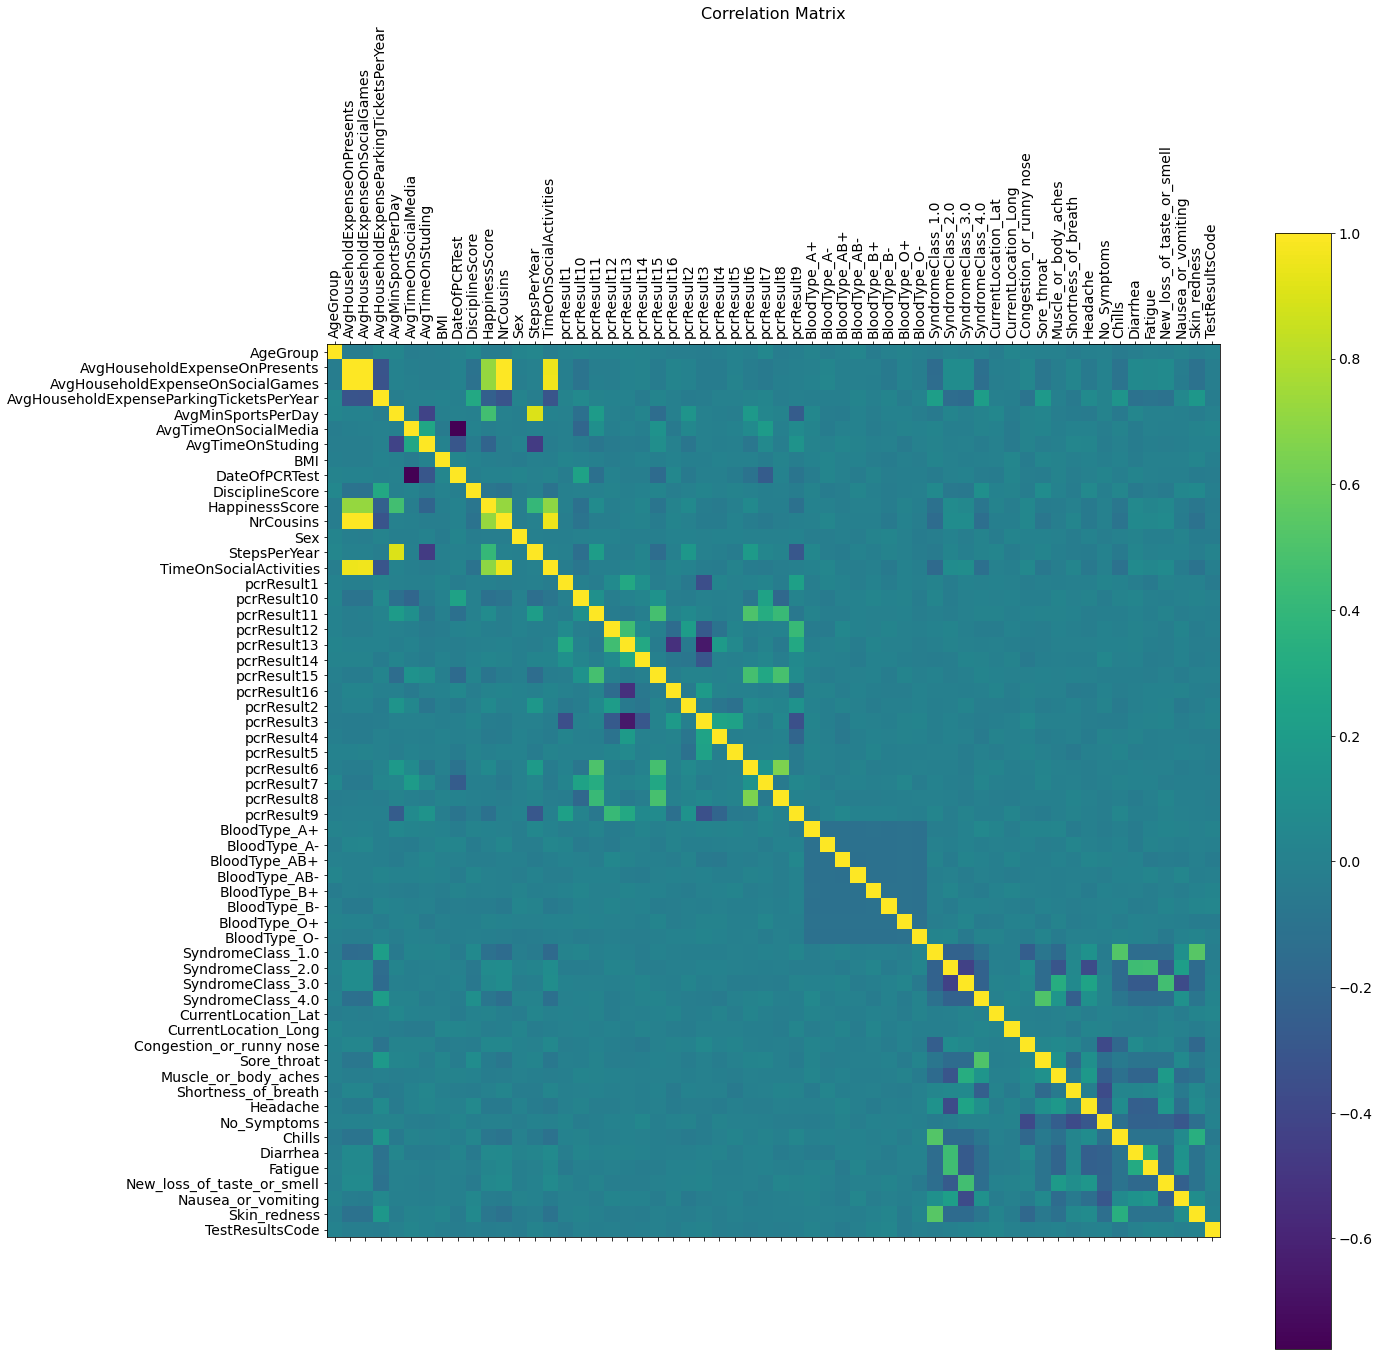

In [31]:
display_correlation_matrix(X_train_prepared, y_train_prepared)

In [ ]:
pd.plotting.scatter_matrix(X_trainn_prepared, figsize=(20,20))

In [32]:
y_train_prepared.dtypes

TestResultsCode    int32
dtype: object